In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import os
print(os.getcwd())

C:\Users\kamil\Desktop\Personal-projects\Fraud_Detection\notebooks


In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(project_root)

C:\Users\kamil\Desktop\Personal-projects\Fraud_Detection


In [4]:
df1_path = os.path.join(project_root, "data/raw/train_transaction.csv")
df2_path = os.path.join(project_root, "data/raw/train_identity.csv")
df1 = pd.read_csv(df1_path)
df2 = pd.read_csv(df2_path)

In [5]:
dataset = df1.merge(df2, how='left')
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
None


In [6]:
dataset.set_index("TransactionID", inplace=True)

In [7]:
# Thanks to spectacular EDA for Columns V https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id#V-Reduced
# 211 V-Columns will be droped

# Define Selected all V-Columns
all_v_columns = [col for col in dataset.columns if col.startswith("V")]

# Define Selected V-Columns
v = [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

# Convert to column names
selected_v_columns = [f"V{i}" for i in v]

# Determine unimportant V-columns (all V-columns - selected V-columns)
not_important_v_columns = list(set(all_v_columns) - set(selected_v_columns))

# Drop unimportant V-columns while keeping everything else
dataset_filtered = dataset.drop(columns=not_important_v_columns)

# Print the shape to confirm changes
print(f"Original Dataset Shape: {dataset.shape}")
print(f"Filtered Dataset Shape: {dataset_filtered.shape}")
print(f"Dropped {len(not_important_v_columns)} Unimportant V-Columns")

Original Dataset Shape: (590540, 433)
Filtered Dataset Shape: (590540, 222)
Dropped 211 Unimportant V-Columns


In [8]:
print(dataset_filtered['isFraud'].sum())

20663


In [9]:
def analyze_dataframe(df):
    """
    Analyzes a dataframe by showing:
    - Data types
    - Unique values count
    - Sample unique values
    - Missing values percentage
    - Basic statistics for numerical columns

    Parameters:
    - df: The dataset to analyze (X_train, X_test, sub_dataset)
    
    Returns:
    - Dataframe with analysis
    """

    # Create a DataFrame to store metadata
    df_info = pd.DataFrame({
        "Data Type": df.dtypes,
        "Unique Values": df.nunique(),
        "Missing Values (%)": df.isnull().mean() * 100,
        "Sample Values": df.apply(lambda x: x.dropna().unique()[:5])  # Show up to 5 unique values as sample
    })

    # Descriptive Stats for Numerical Columns
    numerical_stats = df.describe().T
    
    # Merge results
    df_analysis = df_info.join(numerical_stats, how="left")

    return df_analysis

In [10]:
for col in dataset_filtered.columns:
    if dataset_filtered[col].dtype=='float64': dataset_filtered[col] = dataset_filtered[col].astype('float32')
    if dataset_filtered[col].dtype=='int64': dataset_filtered[col] =dataset_filtered[col].astype('int32')


In [11]:
# Show all columns
pd.set_option("display.max_columns", None)
# Show all rows (optional)
pd.set_option("display.max_rows", None)
# Prevent truncation of long cell values
pd.set_option("display.max_colwidth", None)

df_analysis = analyze_dataframe(dataset_filtered)
print(df_analysis)

               Data Type  Unique Values  Missing Values (%)  \
isFraud            int32              2            0.000000   
TransactionDT      int32         573349            0.000000   
TransactionAmt   float32          20902            0.000000   
ProductCD         object              5            0.000000   
card1              int32          13553            0.000000   
card2            float32            500            1.512683   
card3            float32            114            0.265012   
card4             object              4            0.267044   
card5            float32            119            0.721204   
card6             object              4            0.266028   
addr1            float32            332           11.126427   
addr2            float32             74           11.126427   
dist1            float32           2651           59.652352   
dist2            float32           1751           93.628374   
P_emaildomain     object             59           15.99

In [12]:
def apply_magic_features(df, group_cols=["card1", "card2", "addr1"]):
    """
    Applies advanced feature engineering based on Chris Deotte's 'Magic Features' approach.
    
    Parameters:
    - df: The dataset (train, test, or submission)
    - group_cols: Columns used for grouping and extracting time-based patterns
    
    Returns:
    - df with new "magic" features
    """

    df = df.copy()

    # 1️⃣ **Compute time difference features** (grouped by card)
    if "card1" in df.columns:
        time_diff_card1 = df.groupby("card1")["TransactionDT"].diff().fillna(999999)
    else:
        time_diff_card1 = pd.Series(999999, index=df.index)
    
    if "card2" in df.columns:
        time_diff_card2 = df.groupby("card2")["TransactionDT"].diff().fillna(999999)
    else:
        time_diff_card2 = pd.Series(999999, index=df.index)
    
    group_cols = ["card1", "card2", "addr1"]
    if all(col in df.columns for col in group_cols):
        time_diff_card_addr = df.groupby(group_cols)["TransactionDT"].diff().fillna(999999)
    else:
        time_diff_card_addr = pd.Series(999999, index=df.index)
    
    # 2️⃣ **Frequency Encoding (Count Features)**
    freq_cols = ["card1", "card2", "addr1"]
    count_features = {col: df[col].map(df[col].value_counts()) for col in freq_cols}
    
    # 3️⃣ **Mean Transaction Amount Per Group**
    mean_transaction_amt = {col: df.groupby(col)["TransactionAmt"].transform("mean") for col in freq_cols}
    
    # 4️⃣ **Transaction Amount Ratio (Normalized Spending)**
    transaction_amt_ratio = {
        col: df["TransactionAmt"] / (mean_transaction_amt[col] + 1e-6) for col in freq_cols
    }

    # ✅ **Batch update DataFrame to avoid fragmentation**
    new_features = pd.DataFrame({
        "time_diff_card1": time_diff_card1,
        "time_diff_card2": time_diff_card2,
        "time_diff_card_addr": time_diff_card_addr,
        **{f"{col}_count": count_features[col] for col in freq_cols},
        **{f"{col}_TransactionAmt_mean": mean_transaction_amt[col] for col in freq_cols},
        **{f"{col}_TransactionAmt_ratio": transaction_amt_ratio[col] for col in freq_cols},
    })

    df = pd.concat([df, new_features], axis=1)

    print(f"✅ Applied magic features! New shape: {df.shape}")
    return df


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_and_engineer_features(df, test_size=0.2, random_state=42):
    """Preprocess data: handle missing values, encoding, feature engineering, scaling, and train-test split."""

    df = df.copy()  # Prevent modifying original data

    # 1️⃣ **Handle Missing Values**
    categorical_cols = df.select_dtypes(include=["object"]).columns
    numerical_cols = df.select_dtypes(exclude=["object"]).columns

    # Fill categorical missing values with "Unknown"
    df[categorical_cols] = df[categorical_cols].fillna("Unknown")

    # Define feature groups
    fraud_sensitive_features = ["TransactionAmt"] + [col for col in df.columns if col.startswith('V')]
    categorical_like_numeric = [col for col in df.columns if col.startswith(('C', 'D', 'dist'))]

    # Fill missing values
    df[categorical_like_numeric] = df[categorical_like_numeric].fillna(0)  # Fill categorical-like numeric with 0
    df[fraud_sensitive_features] = df[fraud_sensitive_features].apply(lambda x: x.fillna(x.median()))  # Fill with median

    # Fill missing card & email-related features with mode
    card_email_features = ["card4", "card6", "P_emaildomain", "R_emaildomain"]
    for col in card_email_features:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # 2️⃣ **Categorical Encoding**
    def encode_categorical_features(df, categorical_cols):
        """Encodes categorical columns safely, handling unseen categories."""
        for col in categorical_cols:
            df[col] = df[col].astype("category").cat.codes  # ✅ Assigns -1 to unseen categories
        return df

    categorical_enc_cols = ["ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain",
                            "id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29",
                            "id_30", "id_31", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38",
                            "DeviceType", "DeviceInfo", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"]

    df = encode_categorical_features(df, categorical_enc_cols)

    # 3️⃣ **Fix Performance Warning - Create UID Efficiently**
    df = df.copy()  # Defragmentation Trick!
    df["UID"] = df[["card1", "card2", "addr1"]].astype(str).agg("_".join, axis=1)

    # 4️⃣ **Feature Aggregation (Grouped Statistics)**
    agg_features = df.groupby("UID").agg({
        "TransactionAmt": ["mean", "std", "min", "max", "sum"],  # Spending behavior
        "dist1": ["mean", "std", "min", "max"],  # Distance-based anomalies
        "TransactionDT": ["count"],  # Transaction frequency
    }).reset_index()

    # Rename columns
    agg_features.columns = ["UID"] + [f"UID_" + "_".join(col) for col in agg_features.columns[1:]]

    # Merge aggregated features (Use `merge()` efficiently)
    df = pd.merge(df, agg_features, on="UID", how="left", copy=False)

    # Fill missing values in aggregation columns
    df.fillna(0, inplace=True)

    # 5️⃣ **Derived Features (New Features)**
    df["Amt_C1_Ratio"] = df["TransactionAmt"] / (df["C1"] + 1)  # Prevent division by zero
    df["Amt_D1_Ratio"] = df["TransactionAmt"] / (df["D1"] + 1)
    df["Amt_Dist1_Ratio"] = df["TransactionAmt"] / (df["dist1"] + 1)
    df["Amt_Time_Ratio"] = df["TransactionAmt"] / (df["TransactionDT"] + 1)

    # 6️⃣ **Frequency Encoding**
    df["card1_counts"] = df["card1"].map(df["card1"].value_counts())

    # 7️⃣ **Train-Test Split**
    X = df.drop(columns=["isFraud", "UID"], errors="ignore")
    y = df["isFraud"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # 8️⃣ **Feature Scaling**
    def detect_numeric_columns(df, threshold=10):
        """Detect numerical columns that should be scaled, ignoring binary/categorical-like features."""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        filtered_cols = []
        for col in numeric_cols:
            unique_values = df[col].dropna().to_numpy()  # ✅ Convert to NumPy array
            if len(np.unique(unique_values)) > threshold and not np.all(np.isin(unique_values, [0, 1])):  # ✅ Fix check
                filtered_cols.append(col)
        return filtered_cols

    columns_to_scale = detect_numeric_columns(X_train)

    scaler = StandardScaler()
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    print(f"✅ Preprocessing Complete! Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


In [17]:
dataset_handled = apply_magic_features(dataset_filtered)

✅ Applied magic features! New shape: (590540, 234)


In [18]:
X_train, X_test, y_train, y_test = preprocess_and_engineer_features(dataset_handled)

✅ Preprocessing Complete! Train Shape: (472432, 248) | Test Shape: (118108, 248)


In [19]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

print("\n✅ First 5 rows of X_train:")
print(X_train.head())

print("\n✅ First 5 rows of y_train:")
print(y_train.head())
X_train.describe().T[['mean', 'std']].head(10)  # Check first 10 scaled columns

print("\n✅ Checking encoded categorical columns:")
categorical_columns = ["ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain"]
print(X_train[categorical_columns].head())

# Check unique values
print("\nUnique values after encoding:")
for col in categorical_columns:
    print(f"{col}: {X_train[col].unique()[:5]}")  # First 5 unique values
common_values = set(X_train.index).intersection(set(X_test.index))
print(f"\n🔍 Common indices between X_train and X_test: {len(common_values)} (should be 0)")

print("\n✅ Checking fraud ratio:")
print(f"Fraud in full dataset: {y_train.mean():.4f}")
print(f"Fraud in train set: {y_train.mean():.4f}")
print(f"Fraud in test set: {y_test.mean():.4f}")

print("\n✅ Data Preprocessing Check Completed!")


X_train shape: (472432, 248), X_test shape: (118108, 248)
y_train shape: (472432,), y_test shape: (118108,)

✅ First 5 rows of X_train:
        TransactionDT  TransactionAmt  ProductCD     card1     card2  \
40809       -1.378728       -0.145302          2 -0.759998  0.257853   
285886      -0.079104       -0.435353          4 -0.408558 -0.074010   
104256      -1.148460       -0.112365          4  0.364489 -1.512083   
507860       1.283733        0.442796          4 -1.486336 -0.184631   
196382      -0.641418       -0.074871          4  0.790786 -0.362854   

           card3  card4     card5  card6     addr1     addr2     dist1  \
40809  -0.203484      1 -1.078432      2  0.042876  0.360192 -0.196545   
285886 -0.203484      3  0.588719      3 -0.869556  0.360192 -0.180097   
104256 -0.203484      4  0.633778      2 -0.507599  0.360192 -0.196545   
507860 -0.203484      2 -2.159828      2  0.540566  0.360192 -0.184209   
196382 -0.203484      4  0.633778      3  1.377591  0.360192 


🔍 Top 50 Most Important Features:
                       Feature  Importance
150                       V258    0.190624
89                         V91    0.050182
81                         V70    0.041788
18                          C4    0.035597
125                       V187    0.028390
166                       V294    0.020475
178                       V332    0.019856
22                          C8    0.019807
28                         C14    0.017830
73                         V48    0.015660
15                          C1    0.014954
8                        card6    0.014518
159                       V281    0.012950
31                          D3    0.012641
138                       V224    0.011961
130                       V207    0.010064
160                       V283    0.010006
111                       V156    0.009607
26                         C12    0.009217
212                      id_32    0.008248
30                          D2    0.007826
25                 

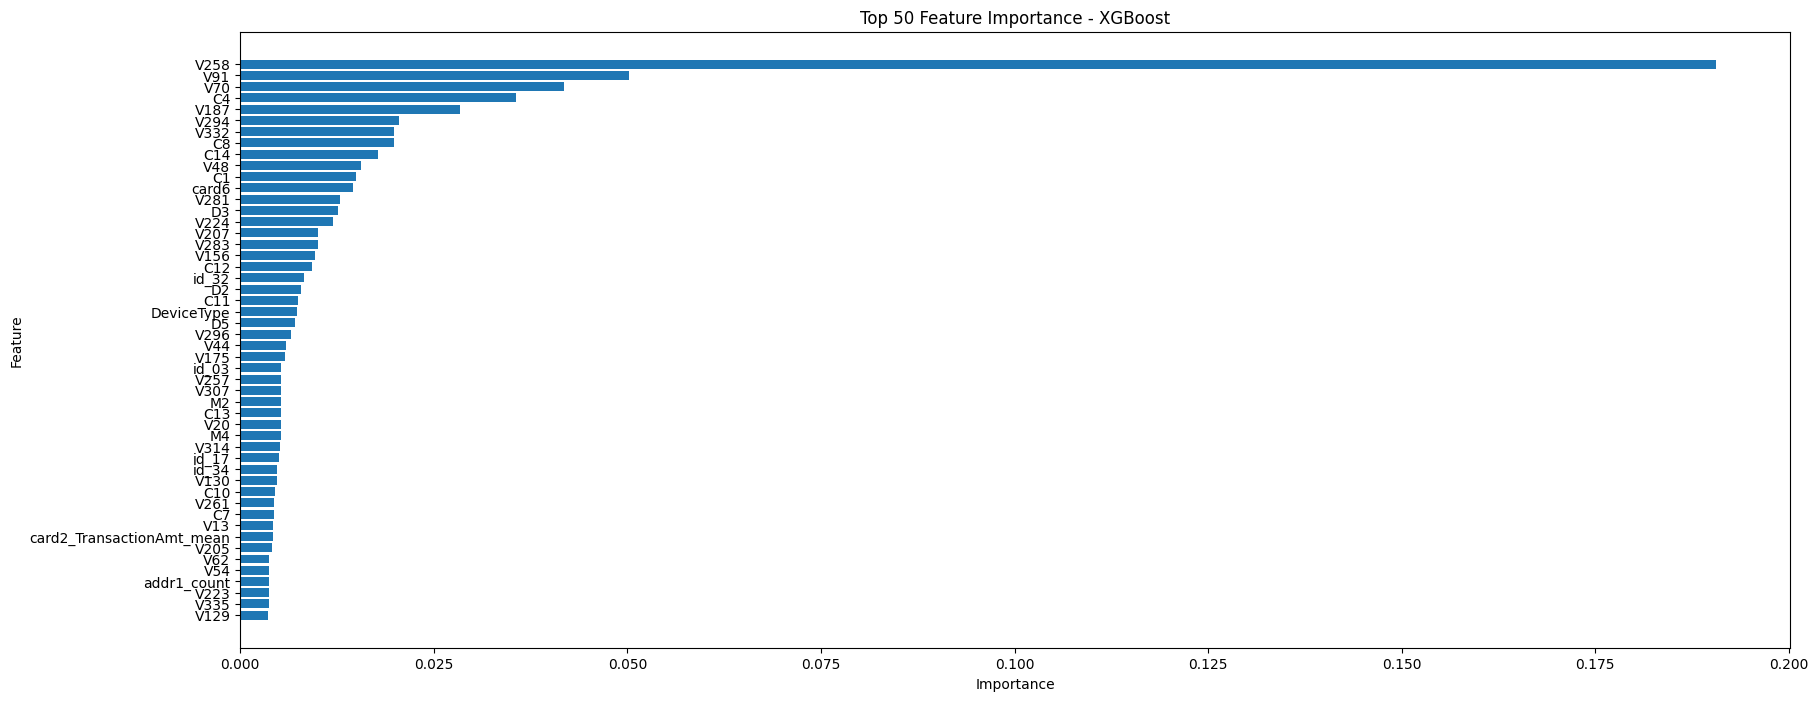

In [20]:
import xgboost as xgb
import matplotlib.pyplot as plt


xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    nthread = -1,
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
print("\n🔍 Top 50 Most Important Features:")
print(feature_importance.head(50))

# Plot feature importance
plt.figure(figsize=(20, 8))
plt.barh(feature_importance["Feature"].head(50), feature_importance["Importance"].head(50))
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 50 Feature Importance - XGBoost")
plt.show()


In [21]:
cumulative_importance_threshold=1

# Compute cumulative importance
feature_importance["Cumulative_Importance"] = feature_importance["Importance"].cumsum()

if cumulative_importance_threshold == 0.99:
    selected_features = feature_importance["Feature"].tolist()
else:
    selected_features = feature_importance[feature_importance["Cumulative_Importance"] <= cumulative_importance_threshold]["Feature"].tolist()

print(f"✅ Selected {len(selected_features)} features (Explaining {cumulative_importance_threshold*100}% of total importance)")


✅ Selected 248 features (Explaining 100% of total importance)


In [22]:
# Apply selected features to X_train and X_test
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f"✅ X_train and X_test updated with {len(selected_features)} selected features.")

✅ X_train and X_test updated with 248 selected features.


In [23]:
non_numeric_columns = X_train.select_dtypes(exclude=['number']).columns
print(f"⚠️ Non-numeric columns found in X_train: {list(non_numeric_columns)}")

⚠️ Non-numeric columns found in X_train: []


In [24]:
missing_per_column = X_train.isnull().sum()
print(missing_per_column[missing_per_column > 0])


Series([], dtype: int64)


In [25]:
missing_per_column = X_test.isnull().sum()
print(missing_per_column[missing_per_column > 0])


Series([], dtype: int64)


In [26]:
print(X_train.dtypes.value_counts())

float64    185
float32     38
int8        25
Name: count, dtype: int64


In [27]:
print(X_test.dtypes.value_counts())

float64    185
float32     38
int8        25
Name: count, dtype: int64


In [28]:
X_train = X_train.astype({col: "int32" for col in X_train.select_dtypes(include=["int64"]).columns})
X_test = X_test.astype({col: "int32" for col in X_test.select_dtypes(include=["int64"]).columns})
X_train = X_train.astype({col: "float32" for col in X_train.select_dtypes(include=["float64"]).columns})
X_test = X_test.astype({col: "float32" for col in X_test.select_dtypes(include=["float64"]).columns})
print("✅ Converted all int64 columns to int32 and all float64 to float32")

✅ Converted all int64 columns to int32 and all float64 to float32


In [29]:
print(X_train.dtypes.value_counts())
print(X_test.dtypes.value_counts())

float32    223
int8        25
Name: count, dtype: int64
float32    223
int8        25
Name: count, dtype: int64


In [30]:
missing_in_test = set(X_train.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train.columns)

if missing_in_test or missing_in_train:
    print(f"⚠️ Columns in train but not in test: {missing_in_test}")
    print(f"⚠️ Columns in test but not in train: {missing_in_train}")


In [31]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Ensure shapes are correct
print(f"🔹 X_train shape: {X_train_np.shape}")
print(f"🔹 X_test shape: {X_test_np.shape}")


🔹 X_train shape: (472432, 248)
🔹 X_test shape: (118108, 248)


In [32]:
import pickle
processed_data_path = os.path.join(project_root, "data/processed/XBG_FE_processed_data.pkl")

with open(processed_data_path, "wb") as f:
    pickle.dump({"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}, f)
